## Object Detection for Waste Segregation

**Problem Statement:**

Segregating solid waste is a big challenge across the globe. Different types of solid waste (like HDPE, PET, GLASS, METAL) has different recycling process. We can use Robots and other automation technologies to separate the waste at high speed from the conveyor belt. And using computer vision to detect the type of the waste and segregating accordingly can increase the efficiency. In this project, we are peforming object detection to identify different types of waste.

Data Source: [Kaggle](https://www.kaggle.com/datasets/arkadiyhacks/drinking-waste-classification)

In [2]:
%%capture
""" Install dependencies """
!pip install ultralytics

In [3]:
""" Import libraries """
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Preprocessing

The data was in the format of .jpg + .txt files in the same folder. To split the data into train, test and validation, we ran code on local and then uploaded the splitted data on the drive to run the training on GPU.

In [4]:
""" Define the class to split the data & store in the format required by YOLO """

class DataPreProcessor:
    def __init__(self, data_directory, train_data_directory, validation_data_directory, test_data_directory):
        self.data_directory = data_directory
        self.train_data_directory = train_data_directory
        self.validation_data_directory = validation_data_directory
        self.test_data_directory = test_data_directory

        os.makedirs(self.train_data_directory, exist_ok=True)
        os.makedirs(self.validation_data_directory, exist_ok=True)
        os.makedirs(self.test_data_directory, exist_ok=True)

    """ Function to split and sort the data into train, val and test folders """

    def sort_dataset(self, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
        image_files = [f for f in os.listdir(self.data_directory) if f.endswith('.jpg')]
        random.shuffle(image_files)

        train_files_all, test_validation_files_all = train_test_split(image_files, test_size=(1 - train_ratio), 
                                                                      random_state=42)
        validation_files_all, test_files_all = train_test_split(test_validation_files_all, 
                                                                test_size=(test_ratio / (test_ratio + val_ratio)), 
                                                                random_state=42)

        self.move_files_in_folders(train_files_all, self.train_data_directory)
        self.move_files_in_folders(validation_files_all, self.validation_data_directory)
        self.move_files_in_folders(test_files_all, self.test_data_directory)

    """ Function to copy jpg and txt files from main dataset folder to the respective destination directory """

    def move_files_in_folders(self, files, destination_directory):
        for filename in files:
            image_directory = os.path.join(self.data_directory, filename)
            label_directory = os.path.join(self.data_directory, filename.replace('.jpg', '.txt'))
            if os.path.exists(label_directory):
                shutil.copy(image_directory, os.path.join(destination_directory, filename))
                shutil.copy(label_directory, os.path.join(destination_directory, filename.replace('.jpg', '.txt')))


After pre-proecessing, the data is converted into following format:

**dataset(train(images,labels), test(images, labels), val(images,labels)**.



### Fine-Tuning YOLO

In [5]:
""" Class to import the YOLO V8 model and fine tune it with custom data """

class ModelTrainer:
    def __init__(self, model_path):
        self.model = YOLO()
        self.model_path = model_path

    """ This function will change the working directory to the folder on the drive so we can download the model 
        if the runtime disconnects."""
    def change_working_directory(self, directory):
        os.chdir(directory)
        print(os.getcwd())

    def train_model(self, yaml_file_path, epochs=30):
        self.model.train(data=yaml_file_path, epochs=epochs)


### Predicting with Fine-Tuned YOLO V8

In [71]:
""" Class to perform the object detection and predict based on the training """

class ModelPredictor:
    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def object_detection(self, test_images_path):
        test_images = [f for f in os.listdir(test_images_path) if f.endswith('.jpg') or f.endswith('.png')]

        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

        for i, image_file in enumerate(test_images):
            """ Loading the images from the test folders """
            image_directory = os.path.join(test_images_path, image_file)
            image = cv2.imread(image_directory)

            """ Predict the results based on the trained model """
            results = self.model.predict(source=image_directory, classes=[0,1,2,3], conf=0.25)

            """ Plot the images in 9 x 9 grid """
            ax = axes[i // 3, i % 3]
            ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            """ Plot the bounding boxes """
            for result in results:
                boxes = result.boxes.xyxy.cpu().numpy() 
                probs = result.boxes.conf.cpu().numpy()
                names = result.names

                """ Define the custom labels (waste type) for each class """
                for j, box in enumerate(boxes):
                    item = result.boxes.cls[j]
                    #print(item)
                    detected_class = int(item.item())
                    x1, y1, x2, y2 = box
                    class_prob = probs[j]
                    class_id = int(class_prob.argmax())
                    # print(class_id)
                    if detected_class == 0:
                        waste_type = 'Metal'
                    elif detected_class == 1:
                        waste_type = 'Glass'
                    elif detected_class == 2:
                        waste_type = 'HDPE'
                    elif detected_class == 3:
                        waste_type = 'PET'
                    else:
                        waste_type = 'Unknown'
                    ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', linewidth=2, 
                                               fill=False))
                    ax.text(x1, y1, f"{waste_type}-{class_prob:.2f}", color='white', backgroundcolor='red', 
                            fontsize=8)
                    x_0 = (x1 + x2) / 2
                    y_0 = (y1 + y2) / 2
                    print(f"{waste_type} Detected at ({x_0},{y_0})")

            ax.axis('off')

    plt.tight_layout()
    plt.show()


### Calling Functions

In [ ]:
""" Load the data """
data_directory = 'C:\\aiprojects\\deep-learning\\object_waste_detection\\dataset\\YOLO_imgs'
train_data_directory = 'C:\\aiprojects\\deep-learning\\object_waste_detection\\train'
validation_data_directory = 'C:\\aiprojects\\deep-learning\\object_waste_detection\\validation'
test_data_directory = 'C:\\aiprojects\\deep-learning\\object_waste_detection\\test'

preprocessor = DataPreProcessor(data_directory, train_data_directory, validation_data_directory, 
                                test_data_directory)
preprocessor.sort_dataset()

""" Keeping only jpg and txt files in respective folders """
for directory in [train_data_directory, validation_data_directory, test_data_directory]:
    image_folder = os.path.join(directory, 'images')
    label_folder = os.path.join(directory, 'labels')

    for file in os.listdir(image_folder):
        if file.endswith('.txt'):
            os.remove(os.path.join(image_folder, file))

    for file in os.listdir(label_folder):
        if file.endswith('.jpg'):
            os.remove(os.path.join(label_folder, file))

In [9]:
""" Training the YOLO model with custom dataset """

model_path = '/content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/Trained_Models/Model_03'
yaml_file_path = '/content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/data.yaml'

trainer = ModelTrainer(model_path)
trainer.change_working_directory(model_path)
trainer.train_model(yaml_file_path, epochs=30)

/content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/Trained_Models/Model_03
Ultralytics YOLOv8.1.41 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

100%|██████████| 755k/755k [00:00<00:00, 36.6MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/Dataset/train/labels.cache... 481 images, 0 backgrounds, 1 corrupt: 100%|██████████| 481/481 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/Dataset/train/images/AluCan87.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0339]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/Dataset/val/labels.cache... 193 images, 0 backgrounds, 0 corrupt: 100%|██████████| 193/193 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G     0.9517      3.041      1.146         34        640: 100%|██████████| 30/30 [07:51<00:00, 15.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [02:29<00:00, 21.32s/it]

                   all        193        206      0.616      0.131      0.381      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      0.959      2.181      1.133         34        640: 100%|██████████| 30/30 [07:38<00:00, 15.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:57<00:00,  8.16s/it]

                   all        193        206      0.421      0.395      0.515      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G      1.033      1.997      1.197         35        640: 100%|██████████| 30/30 [07:31<00:00, 15.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<00:00,  7.87s/it]

                   all        193        206      0.644      0.282      0.277      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      1.043      1.929      1.225         31        640: 100%|██████████| 30/30 [07:39<00:00, 15.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.61s/it]

                   all        193        206      0.499      0.589      0.597       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G      1.015      1.757      1.197         34        640: 100%|██████████| 30/30 [07:28<00:00, 14.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:59<00:00,  8.44s/it]

                   all        193        206       0.72      0.637      0.712      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.033      1.609      1.198         39        640: 100%|██████████| 30/30 [07:28<00:00, 14.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<00:00,  7.72s/it]

                   all        193        206      0.755      0.727      0.784      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G     0.9635      1.469      1.146         32        640: 100%|██████████| 30/30 [07:20<00:00, 14.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.69s/it]

                   all        193        206      0.735      0.808       0.78       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G          1      1.417      1.178         39        640: 100%|██████████| 30/30 [07:32<00:00, 15.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.70s/it]

                   all        193        206      0.741      0.763      0.812      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G     0.9423      1.361      1.148         36        640: 100%|██████████| 30/30 [07:29<00:00, 14.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:58<00:00,  8.38s/it]

                   all        193        206      0.749      0.832      0.832       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G     0.9317      1.286      1.138         42        640: 100%|██████████| 30/30 [07:38<00:00, 15.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.61s/it]

                   all        193        206      0.735      0.792      0.843       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      0.941      1.187      1.163         35        640: 100%|██████████| 30/30 [07:20<00:00, 14.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<00:00,  7.81s/it]

                   all        193        206      0.876      0.766      0.901      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G     0.9915      1.199      1.176         37        640: 100%|██████████| 30/30 [07:32<00:00, 15.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<00:00,  7.84s/it]

                   all        193        206      0.844      0.879      0.926       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G     0.9096      1.123      1.123         34        640: 100%|██████████| 30/30 [07:38<00:00, 15.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<00:00,  7.84s/it]

                   all        193        206      0.842      0.802      0.897      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G     0.8986      1.068      1.126         30        640: 100%|██████████| 30/30 [07:30<00:00, 15.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.61s/it]

                   all        193        206      0.841      0.859      0.918      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G     0.8485     0.9871      1.097         33        640: 100%|██████████| 30/30 [07:29<00:00, 14.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:51<00:00,  7.40s/it]

                   all        193        206      0.877       0.87      0.931      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G     0.8528     0.9768      1.093         26        640: 100%|██████████| 30/30 [07:26<00:00, 14.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.69s/it]

                   all        193        206      0.888      0.854      0.929      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G     0.8459     0.9302      1.076         32        640: 100%|██████████| 30/30 [07:27<00:00, 14.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:52<00:00,  7.49s/it]

                   all        193        206      0.939      0.924      0.966      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G     0.8158      0.901      1.096         32        640: 100%|██████████| 30/30 [07:35<00:00, 15.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.63s/it]

                   all        193        206      0.856      0.845      0.933      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G     0.8186     0.8662      1.097         43        640: 100%|██████████| 30/30 [07:34<00:00, 15.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<00:00,  7.91s/it]

                   all        193        206      0.859      0.907      0.938      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G     0.8146     0.8605      1.085         46        640: 100%|██████████| 30/30 [07:28<00:00, 14.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.59s/it]

                   all        193        206      0.917      0.923      0.956      0.771


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G     0.6779     0.8202     0.9988         17        640: 100%|██████████| 30/30 [07:24<00:00, 14.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:52<00:00,  7.43s/it]

                   all        193        206        0.9      0.884       0.95      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G     0.6582     0.7456     0.9666         19        640: 100%|██████████| 30/30 [07:22<00:00, 14.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.60s/it]

                   all        193        206      0.913      0.891      0.956      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G      0.663     0.7153     0.9873         16        640: 100%|██████████| 30/30 [07:16<00:00, 14.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.63s/it]

                   all        193        206      0.913      0.912      0.955      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G     0.6549     0.6813     0.9825         16        640: 100%|██████████| 30/30 [07:29<00:00, 14.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.58s/it]

                   all        193        206      0.922      0.914      0.955      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G     0.6397     0.6542     0.9723         16        640: 100%|██████████| 30/30 [07:18<00:00, 14.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<00:00,  7.80s/it]

                   all        193        206      0.947      0.919      0.962      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G     0.6269     0.6276     0.9679         16        640: 100%|██████████| 30/30 [07:17<00:00, 14.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:53<00:00,  7.57s/it]

                   all        193        206      0.937      0.898      0.961      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G      0.616     0.6122     0.9645         16        640: 100%|██████████| 30/30 [07:26<00:00, 14.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:51<00:00,  7.40s/it]

                   all        193        206      0.923      0.926      0.969      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G     0.5994     0.5966     0.9449         19        640: 100%|██████████| 30/30 [07:32<00:00, 15.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:55<00:00,  7.99s/it]

                   all        193        206       0.91        0.9      0.958      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G     0.5889     0.5574     0.9517         16        640: 100%|██████████| 30/30 [07:23<00:00, 14.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:52<00:00,  7.57s/it]

                   all        193        206      0.938      0.916      0.968      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G     0.5705     0.5373     0.9226         16        640: 100%|██████████| 30/30 [07:23<00:00, 14.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<00:00,  7.73s/it]

                   all        193        206      0.939      0.935       0.97      0.804



30 epochs completed in 4.228 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.41 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:54<00:00,  7.76s/it]


                   all        193        206       0.94      0.935       0.97      0.804
                     0        193         43      0.891      0.951      0.954      0.735
                     1        193         56      0.949      0.839      0.944      0.767
                     2        193         47      0.927          1      0.993      0.854
                     3        193         60      0.991       0.95      0.991      0.858
Speed: 2.6ms preprocess, 246.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train


#### Testing The Model


image 1/1 /content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/Dataset/testing/AluCan405.jpg: 640x480 1 0, 219.7ms
Speed: 5.0ms preprocess, 219.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
Metal Detected at (302.734130859375,304.46783447265625)

image 1/1 /content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/Dataset/testing/Glass510.jpg: 640x480 1 1, 193.6ms
Speed: 3.4ms preprocess, 193.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)
Glass Detected at (217.27980041503906,333.001953125)

image 1/1 /content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/Dataset/testing/HDPEM929.jpg: 640x480 1 2, 177.0ms
Speed: 3.4ms preprocess, 177.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)
HDPE Detected at (279.47216796875,344.5134582519531)

image 1/1 /content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/Dataset/testing/PET1,221.jpg: 640x480 1 3, 194.0ms
Speed: 3.4ms preprocess, 194.0ms inference, 1.2ms postprocess per i

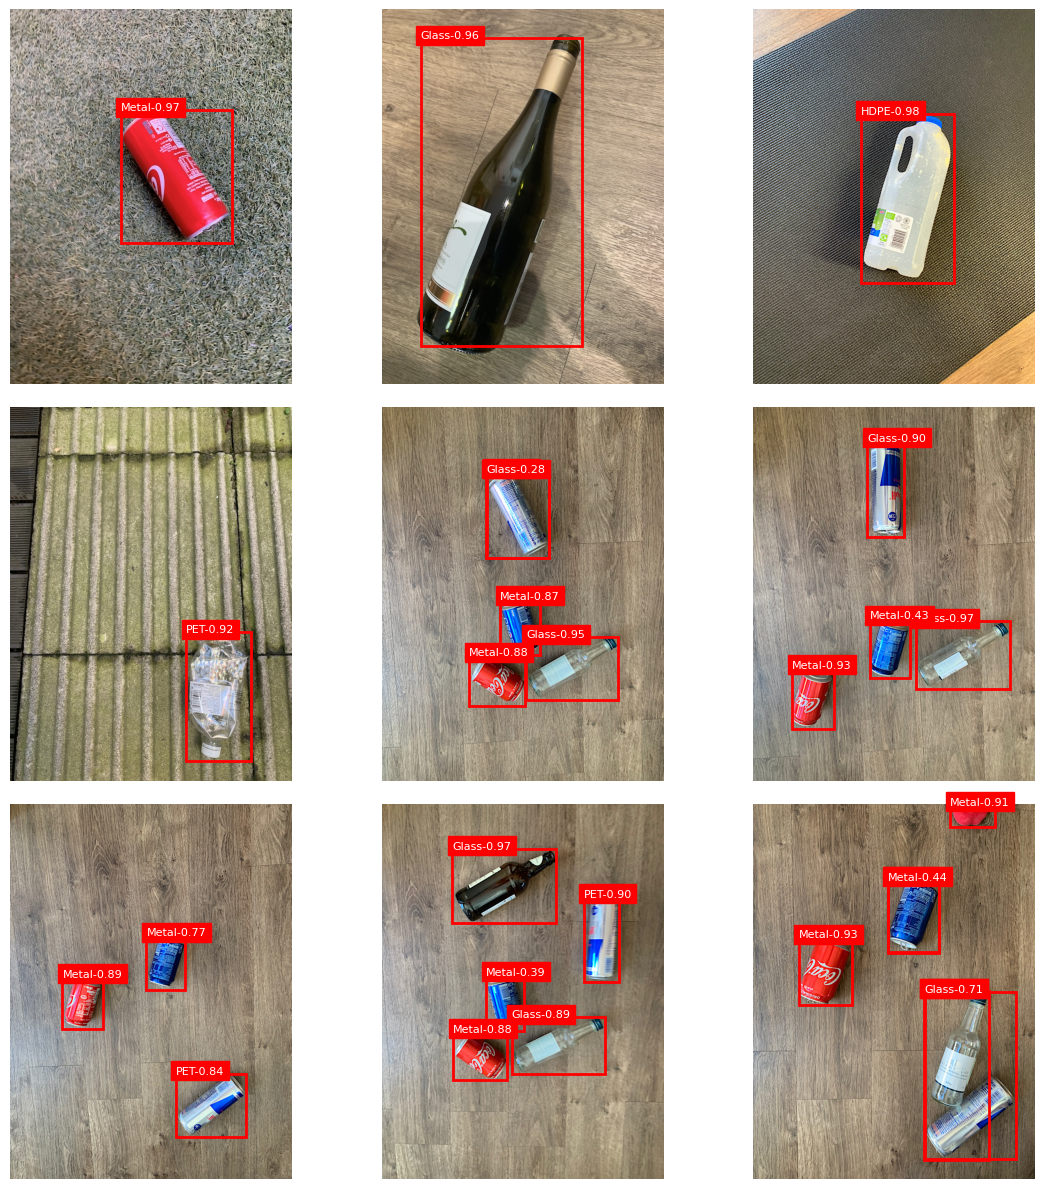

In [72]:
""" Predict with fine-tuned model """

model_path = '/content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/Trained_Models/Model_03/runs/detect/train/weights/best.pt'
test_images_path = '/content/drive/MyDrive/AI_Projects/Object_Detection_Yolo/Dataset/testing'

detector = ModelPredictor(model_path)
detector.object_detection(test_images_path)

### Prediction with Live Stream

Running the live stream locally with trained model.

In [4]:
from ultralytics import YOLO
import cv2

In [16]:
class LiveDetector:
    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def predict_objects(self):
        cap = cv2.VideoCapture(0)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            results = self.model(frame, conf=0.25, iou=0.7)

            for result in results:
                boxes = result.boxes.xyxy.cpu().numpy()
                probs = result.boxes.conf.cpu().numpy()
                names = result.names
                
                for j, box in enumerate(boxes):
                    item = result.boxes.cls[j]
                    detected_class = int(item.item())
                    x1, y1, x2, y2 = box
                    class_prob = probs[j]
                    class_id = int(class_prob.argmax())
                    if detected_class == 0:
                        waste_type = 'Metal'
                    elif detected_class == 1:
                        waste_type = 'Glass'
                    elif detected_class == 2:
                        waste_type = 'HDPE'
                    elif detected_class == 3:
                        waste_type = 'PET'
                    else:
                        waste_type = 'Unknown'
                    cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    cv2.rectangle(frame, (int(x1), int(y1 - 5)), (int(x1)+100, int(y1 - 5)-20), (255,0,0), cv2.FILLED)

                    cv2.putText(frame, f"{waste_type}-{class_prob:.2f}", (int(x1), int(y1 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                    x_0 = (x1 + x2) / 2
                    y_0 = (y1 + y2) / 2
                    print(f"{waste_type} Detected at ({x_0},{y_0})")
            cv2.imshow('Object (Waste) Detection', frame)
            cv2.waitKey(100)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

model_path = 'C:\\aiprojects\\deep-learning\\object_waste_detection\\trained_model\\model_03\\runs\\detect\\train\\weights\\best.pt'
livedetector = LiveDetector(model_path)
livedetector.predict_objects()


0: 480x640 (no detections), 170.1ms
Speed: 4.2ms preprocess, 170.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 3s, 171.2ms
Speed: 2.0ms preprocess, 171.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Glass Detected at (261.214599609375,400.5460205078125)
Glass Detected at (196.9380645751953,400.2430114746094)

0: 480x640 (no detections), 142.5ms
Speed: 1.0ms preprocess, 142.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 3, 134.2ms
Speed: 2.0ms preprocess, 134.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Glass Detected at (369.6485290527344,403.706787109375)

0: 480x640 1 2, 144.0ms
Speed: 3.0ms preprocess, 144.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
HDPE Detected at (208.1311798095703,240.0)

0: 480x640 2 1s, 1 2, 154.5ms
Speed: 2.0ms preprocess, 154.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
PET Detected at (215.3

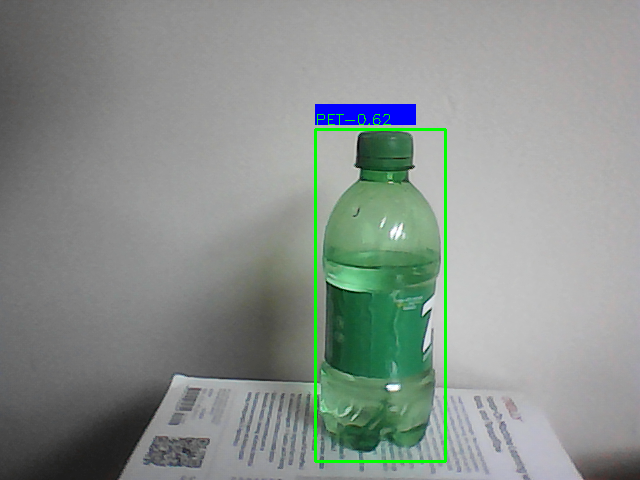
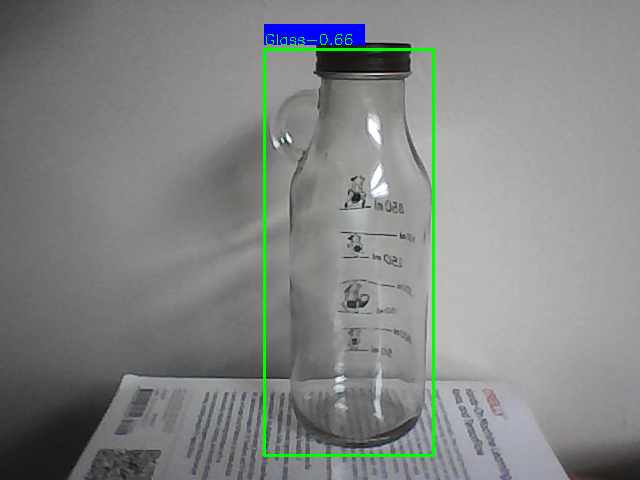

### Visualizations from the trained model

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

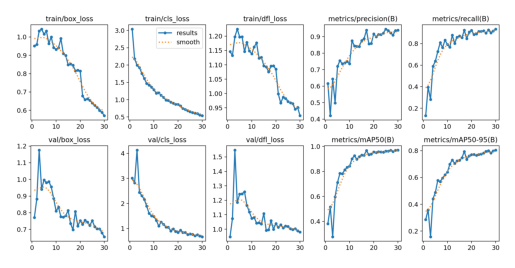

In [3]:
loss_charts = Image.open(r"C:\aiprojects\deep-learning\object_waste_detection\trained_model\model_03\runs\detect\train\results.png")
plt.imshow(loss_charts)
plt.axis('off')
plt.show()

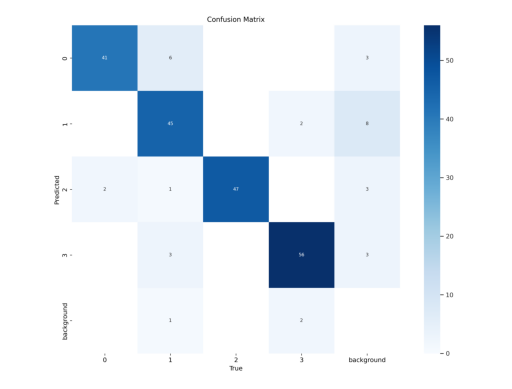

In [21]:
confusion_matrix = Image.open(r"C:\aiprojects\deep-learning\object_waste_detection\trained_model\model_03\runs\detect\train\confusion_matrix.png")
plt.imshow(confusion_matrix)
plt.axis('off')
plt.show()

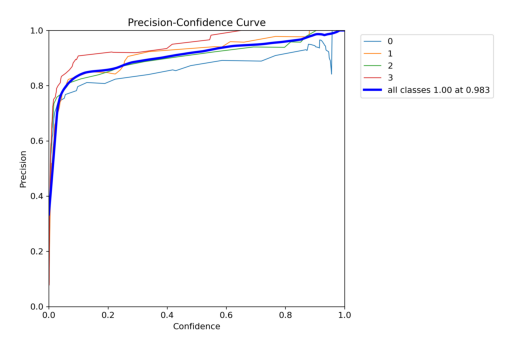

In [22]:
p_curve = Image.open(r"C:\aiprojects\deep-learning\object_waste_detection\trained_model\model_03\runs\detect\train\P_curve.png")
plt.imshow(p_curve)
plt.axis('off')
plt.show()

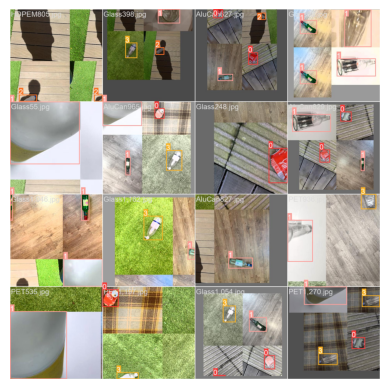

In [23]:
p_curve = Image.open(r"C:\aiprojects\deep-learning\object_waste_detection\trained_model\model_03\runs\detect\train\train_batch0.jpg")
plt.imshow(p_curve)
plt.axis('off')
plt.show()

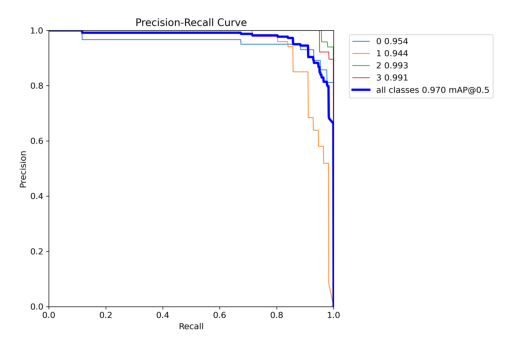

In [24]:
p_curve = Image.open(r"C:\aiprojects\deep-learning\object_waste_detection\trained_model\model_03\runs\detect\train\PR_curve.png")
plt.imshow(p_curve)
plt.axis('off')
plt.show()

### Discussion

The use case of this project is in the solid waste recycling industries to segregate waste using Robots and automation systems after detecting using AI models. We ran couple of experiments with different number of epochs, different confidence score and different number of training to validation ratio to see which combination of the parameters worked better. We started with 200 training images and gradually increased the training images to get better results with optimum training time and we completed the experiments with 963 training images which took around 4.2 hours. Based on the PR curve, we selected the confidence value of 0.25 to get more than 80% of precision in the prediction. From the confusion matrix, we can conclude that the highest false detection is between the class METAL and GLASS which we can also see in the sample testing images. Running the training with more epochs and more number of training images would improve the results.

### Use Case

Solid waste segregation with manual labor (Image credit: [Link](https://www.burlingtoncountytimes.com/story/news/2016/06/27/burlington-county-pushes-to-educate/17597780007/))
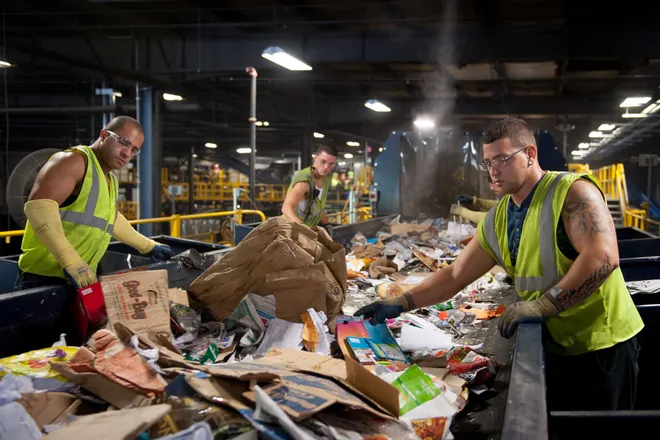

Solid waste segregation with Robots (Image credit: [Link](https://www.wastedive.com/news/recycling-labor-mrf-robots-move-in/568554/))
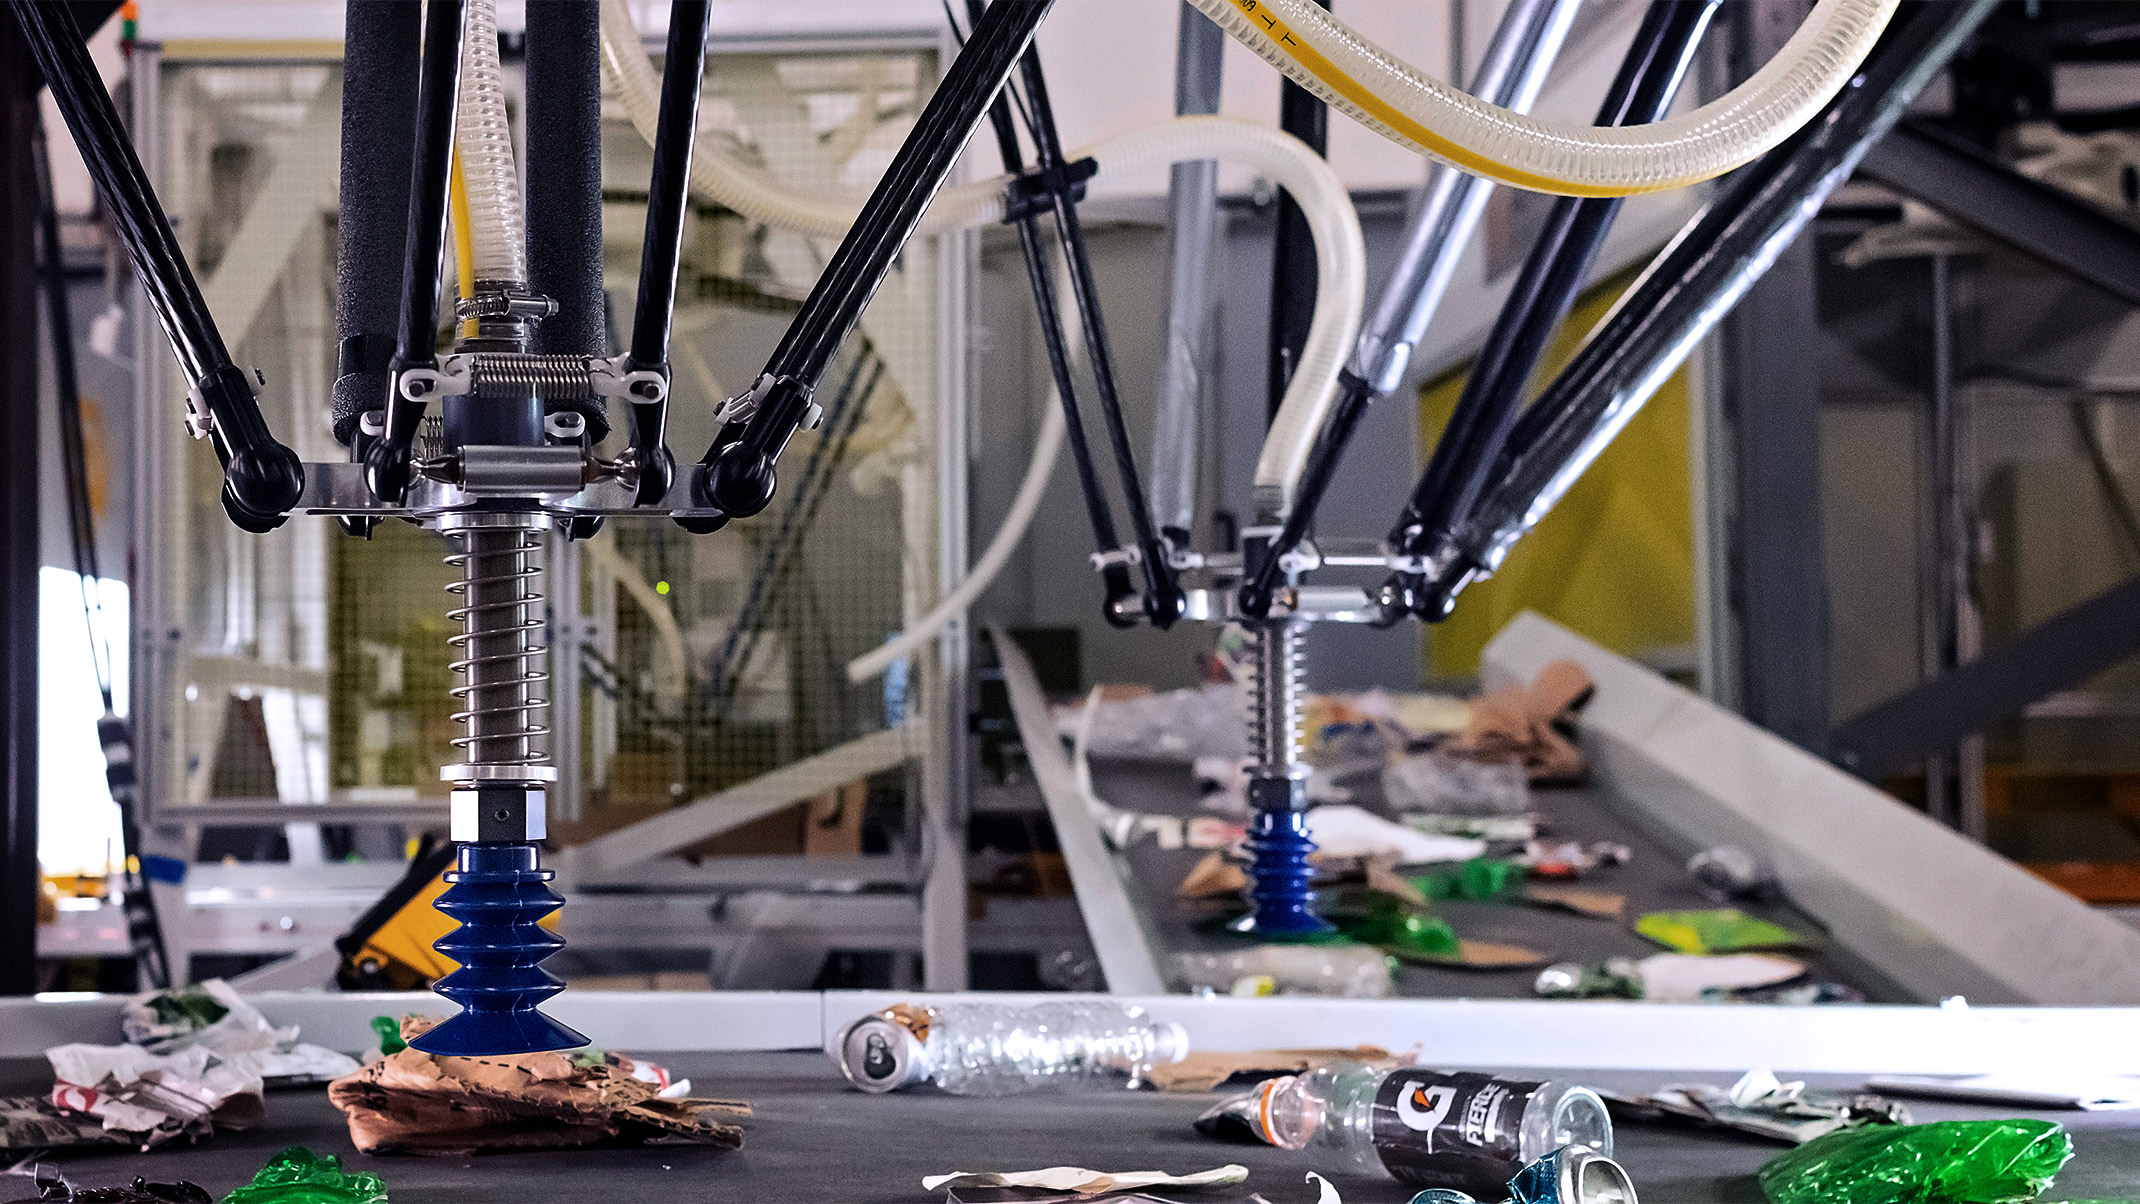